In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os
int=np.vectorize(int)

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nturn = 1
betx  = 1.9065054393933862
alfx  = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
n_particles = 40000
nx   = 100
NL_t = 0.4
NL_c = 0.01
print('singular point = ', NL_c*np.sqrt(betx))
pipe_radius = 0.02*np.sqrt(2.0)
#pipe_radius = 0.013
#pipe_radius = 0.01

singular point =  0.013807626296338507


# 1. Foward

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.n_particles = n_particles

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

### 1.1. generate particles

In [5]:
beamtmp = copy(beam)
beamtmp.distribution.distribution_type = 'IOTA_Waterbag'
beamtmp.distribution.NL_t = NL_t
beamtmp.distribution.NL_c = NL_c
noturn = impact.getElem('loop')
noturn.turns = 0
impact.writeInputFile(beamtmp,[noturn]);
impact.run(beamtmp)
pData = impact.readParticleData(-111110,ke,mass,freq)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


In [6]:
testP = 0.0
sig = 0.01
k=0
q_m = beamtmp.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-0.01,0.01,nx):
    for y in np.linspace(-0.01,0.01,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            

pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)

nptTest= 7668


In [7]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

(47668, 9)


In [8]:
beam.n_particles = n_particles + nptTest
impact.writeInputFile(beam,[noturn]);
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

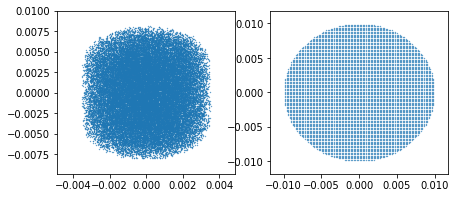

In [9]:
pDataInit = impact.readParticleData(-111110, ke, mass, freq)
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.scatter(pDataInit[nptTest:,0],pDataInit[nptTest:,2],s=0.1);
plt.subplot(1,2,2)
plt.scatter(pDataInit[:nptTest,0],pDataInit[:nptTest,2],s=0.1);

### 1.2 adjust lattice

In [10]:
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = ceil(lattice[i].length*20)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_map = 10
        else:
            lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]

beam.n_particles = n_particles + nptTest
impact.writeInputFile(beam,[noturn]);
impact.run(beam)

0

### 1.3 Run

In [11]:
TBT = impact.getElem('TBT')
TBT.file_id = nturn + 60000
lattice.insert(1,TBT)

lattice[0].turns = nturn
for i in range(len(lattice)):
    if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
        lattice[i].pipe_radius = pipe_radius

237


In [12]:
impact.writeInputFile(beam,lattice) 
impact.run(beam)
pData0 = impact.readParticleData(-111110,ke,mass,freq)
pData1 = impact.readParticleData(-111111,ke,mass,freq)

# 2. Backward

In [ ]:
latticeB = copy(lattice[::-1])
latticeB.insert(0,copy(lattice[0]))
latticeB[0].turns = nturn
latticeB.pop()
latticeB[-1].file_id = nturn+90000

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if 'bending_angle' in latticeB[i]:
         latticeB[i].bending_angle = -latticeB[i].bending_angle
    if 'fringe_field_integration' in latticeB[i]:
         latticeB[i].fringe_field_integration = -latticeB[i].fringe_field_integration      
    if 'KL_sext' in latticeB[i]:
         latticeB[i].KL_sext = -latticeB[i].KL_sext  
        
impact.writeParticleData(pData1,ke,mass,freq)
impact.writeInputFile(beam,latticeB)
impact.run(beam)

In [ ]:
pData2 = impact.readParticleData(-111111,ke,mass,freq)
sampleIndex = np.array(int(pData2[:8,-1]))

In [ ]:
pData2[:8,:]-pData0[sampleIndex-1,:]

In [ ]:
n=14
print(lattice[n],latticeB[-n])